<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

# SVM (Support Vector Machines)

Estimated time needed: **15** minutes

## Objectives

After completing this lab you will be able to:

*   Use scikit-learn to Support Vector Machine to classify


In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#load_dataset">Load the Cancer data</a></li>
        <li><a href="https://#modeling">Modeling</a></li>
        <li><a href="https://#evaluation">Evaluation</a></li>
        <li><a href="https://#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


In [50]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.

**Did you know?** When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)


In [51]:
#Click here and press Shift+Enter
path = "datasets/cell_samples.csv" 
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv"
df = pd.read_csv(filepath_or_buffer=url)
df.to_csv(path_or_buf=path, index=False)

## Load Data From CSV File


In [52]:
cell_df = pd.read_csv("datasets/cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


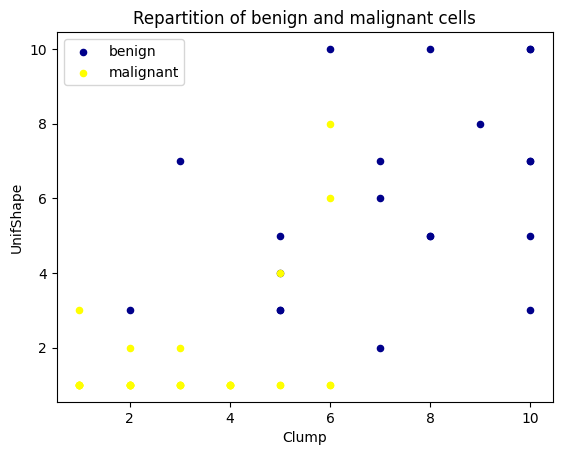

In [53]:
# ax = cell_df[cell_df['Class'] == 4][0:50].plot(
# 	kind='scatter', 
# 	x='Clump', 
# 	y='UnifSize', 
# 	color='DarkBlue', 
# 	label='malignant'
# )
# cell_df[cell_df['Class'] == 2][0:50].plot(
# 	kind='scatter', 
# 	x='Clump', 
# 	y='UnifSize', 
# 	color='Yellow', 
# 	label='benign', 
# 	ax=ax)
# plt.show()

cell_mal = cell_df.loc[0:50,:].loc[cell_df["Class"] == 4]
cell_ben = cell_df.loc[0:50,:].loc[cell_df["Class"] == 2]

ax = cell_mal.plot(
	kind="scatter",
	x="Clump",
	y="UnifShape",
	color="DarkBlue",
	label="benign",
	title="Repartition of benign and malignant cells"
)
ax = cell_ben.plot(
	kind="scatter",
	x="Clump",
	y="UnifShape",
	color="Yellow",
	label="malignant",
	ax=ax
)


## Data pre-processing and selection


Let's first look at columns data types:


In [54]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows:


In [55]:
# let's get rid of the rows where the value of "BareNuc" is non numerical
cell_df = cell_df[
	# will try to convert each value of "BareNuc" to a numerical value
	# if it is not possible, it will mark it as nan
	pd.to_numeric(
		cell_df['BareNuc'], errors='coerce'
	# this will return a boolean array of all the rows that are non null (non nan)
	).notnull()
]
# convert the numerical values to type int
cell_df.loc[:,'BareNuc'] = cell_df.loc[:,'BareNuc'].astype('int')
cell_df.dtypes

/var/folders/sg/d2yjkd7s22zcny48m8_01qpm0000gn/T/ipykernel_76810/2113606514.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cell_df.loc[:,'BareNuc'] = cell_df.loc[:,'BareNuc'].astype('int')


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [56]:
# feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
feature_df = cell_df.loc[:,"Clump":"Mit"]
# X = np.asarray(feature_df)
X = feature_df
X[0:5]

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.


In [57]:
# cell_df['Class'] = cell_df['Class'].astype('int')
# y = np.asarray(cell_df['Class'])
y = cell_df.loc[:,"Class"]
y.loc[0:5]

0    2
1    2
2    2
3    2
4    2
5    4
Name: Class, dtype: int64

## Train/Test dataset


We split our dataset into train and test set:


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


In [59]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

After being fitted, the model can then be used to predict new values:


In [65]:
yhat = clf.predict(X_test)
yhat[0:10] == y_test[0:10]

/var/folders/sg/d2yjkd7s22zcny48m8_01qpm0000gn/T/ipykernel_76810/1102684227.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yhat[0:10] == y_test[0:10]


693    True
669    True
545    True
106    True
185    True
403    True
399    True
280    True
285    True
34     True
Name: Class, dtype: bool

<h2 id="evaluation">Evaluation</h2>


In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


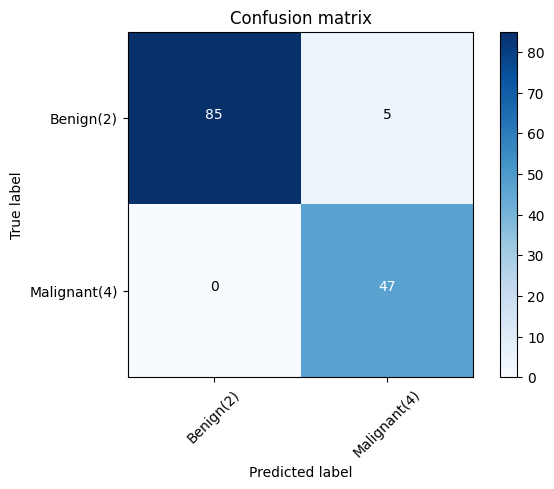

In [68]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

You can also easily use the **f1\_score** from sklearn library:


In [69]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Let's try the jaccard index for accuracy:


In [70]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.9444444444444444

<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?


In [72]:
# write your code here
clf2 = svm.SVC(kernel="linear")
clf2.fit(X=X_train, y=y_train)
yhat2 = clf2.predict(X=X_test)
jaccardScore_clf2 = jaccard_score(y_test, yhat2, pos_label=2)
f1_clf2 = f1_score(y_true = y_test, y_pred = yhat2, average="weighted")
print(f"The f1 score for this second classifier is:  {f1_clf2}\n\
	The jaccard score for this second classifier is: {jaccardScore_clf2}")
print("Conclusion: the kernel choice had no impact on the precision of the model for this dataset")


The f1 score for this second classifier is:  0.9639038982104676
	The jaccard score for this second classifier is: 0.9444444444444444
Conclusion: the kernel choice had no impact on the precision of the model for this dataset


<details><summary>Click here for the solution</summary>

```python
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2,pos_label=2))

```

</details>


### Thank you for completing this lab!

## Author

Saeed Aghabozorgi

### Other Contributors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">Joseph Santarcangelo</a>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                 |
| ----------------- | ------- | ---------- | ---------------------------------- |
| 2021-01-21        | 2.2     | Lakshmi    | Updated sklearn library            |
| 2020-11-03        | 2.1     | Lakshmi    | Updated URL of csv                 |
| 2020-08-27        | 2.0     | Lavanya    | Moved lab to course repo in GitLab |
|                   |         |            |                                    |
|                   |         |            |                                    |

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
